# Analysis of Oktoberfest visitors and the correlation between prices and consumption

## Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from tueplots import bundles
from tueplots.constants.color import rgb
from scipy.stats import ttest_ind

## Load the dataset

In [2]:
# Reading in the Oktoberfest dataset
df = pd.read_csv("dat/oktoberfest.csv", sep=",")
df = df.drop('_id', axis=1)

# Creating a range of years from the minimum to maximum 
all_years = np.arange(df['jahr'].min(), df['jahr'].max() + 1)

# Merge df with the full range of years, filling missing values with NaN
df_all_years = pd.DataFrame({'jahr': all_years})
df = pd.merge(df_all_years, df, on='jahr', how='left')

# Adding a new row for the year 2023
data_2023 = pd.DataFrame({'jahr': [2023], 'dauer': [18], 'besucher_gesamt': [7.2], 'besucher_tag': [400.0], 
                          'bier_preis': [14.33], 'bier_konsum': [65000.0]})  

# Append the new row to the df
df = pd.concat([df, data_2023], ignore_index=True)

Additional visitor and consumption data for 2023 was retrived from: https://www.muenchen.de/veranstaltungen/oktoberfest/aktuell/wiesn-2023-das-ist-die-abschlussbilanz

The beer price for 2023 was calculated as the average across the "Festhallen" from this table: https://stadt.muenchen.de/dam/jcr:2117b3fe-760c-4a9d-8123-38fe54bf49e4/ge-trraenke-wiesn23.pdf. This matches with the way data for previous years was recorded (From the Oktoberfest dataset description: "Die durchschnittlichen Bierpreise für 1 Maß Bier (1 Liter) in den Festzelten auf dem Oktoberfest (Preise in Euro)")

## Visitors to Oktoberfest over the years

We start by getting an overview of the visitor numbers over the years:

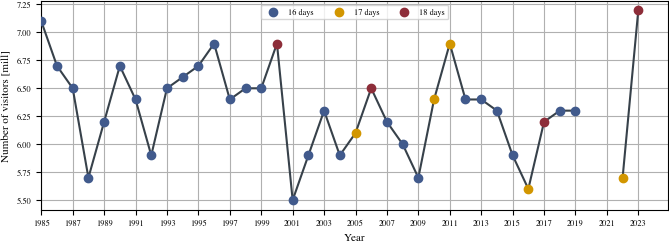

In [3]:
plt.rcParams.update(bundles.icml2022(column="full", nrows=0.6, ncols=1, usetex=False))
colors = {16.0:rgb.tue_darkblue, 17.0:rgb.tue_orange, 18.0:rgb.tue_red}

plt.plot(df['jahr'],df['besucher_gesamt'], color=rgb.tue_dark)

mask = ~np.isnan(df['dauer'])
for dauer, color in colors.items():
    dauer_mask = (df['dauer'] == dauer) & mask
    plt.scatter(df['jahr'][dauer_mask], df['besucher_gesamt'][dauer_mask], color=color, zorder=3, marker='o', label=f'{int(dauer)} days')

plt.xticks(df['jahr'][::2])
plt.xlim(df['jahr'].min())
plt.xlabel("Year")
plt.ylabel("Number of visitors [mill]")
plt.grid(True)
plt.legend(loc="upper center", ncol=3)


plt.savefig('doc/fig/visitor_numbers.pdf')
plt.show()

The graph shows the number of visitors to the Oktoberfest throughout the years, with points coloured based on the duration of the festival that year.

There is a dramatic drop in visitor numbers in the year 2001. A potential explanation could be the 9/11 terrorist attacks that occurred a few weeks prior to the festival.

The Oktoberfest was cancelled in 2020 and 2021 due to the COVID-19 pandemic and, perhaps surprisingly, visitor numbers were still very low during the first festival after the pandemic in 2022. This could be due to the public's remaining fears of contracting the virus in large crowds. 

A new record number of visitors was set in 2023!


### Investigating the significance of the 2001 drop in visitor numbers

From the plot above, we noticed a pretty large drop in numbers in 2001. Is there any significance to this observation?

We can detect outliers by finding years that have a visitor number that is more than 2 standard deviations away from the mean. For this, we only look at festivals that were 16 days long to remove the effect of festival duration on visitor number.

In [4]:
# Calculate the mean and standard deviation 
df_16days = df.loc[df['dauer'] == 16]
avg_visitors = df_16days['besucher_gesamt'].mean()
std_dev = df_16days['besucher_gesamt'].std()

# Define threshold
threshold = 2 * std_dev
range = (avg_visitors - threshold, avg_visitors + threshold)
print(f"Outliers would lie outside of the range: {range}")

# Create a mask to identify outliers
outliers_mask = (df_16days['besucher_gesamt'] > avg_visitors + threshold) | (df_16days['besucher_gesamt'] < avg_visitors - threshold)

# Use the mask to filter df 
outliers_df = df_16days[outliers_mask]

# Print outliers
print("Years with an outlier visitor number:", outliers_df["jahr"].tolist())

Outliers would lie outside of the range: (5.541834572923025, 7.058165427076978)
Years with an outlier visitor number: [1985, 2001]


From this we can see that the year 2001 is indeed an outlier, with abnormally low visitor numbers for a 16-day Oktoberfest. However, the 9/11 terrorist attacks could just be one of many reasons to explain this sudden drop in visitor numbers. The year 1985 is also an outlier, but in this case due to an abnormally high visitor number.

## How does the beer price change over the years and how does it affect the consumption?

We look at how the beer consumption (normalized by the number of visitors) and the beer price change over the years. Then, to investigate how these two factors are related, we also plot their correlation.

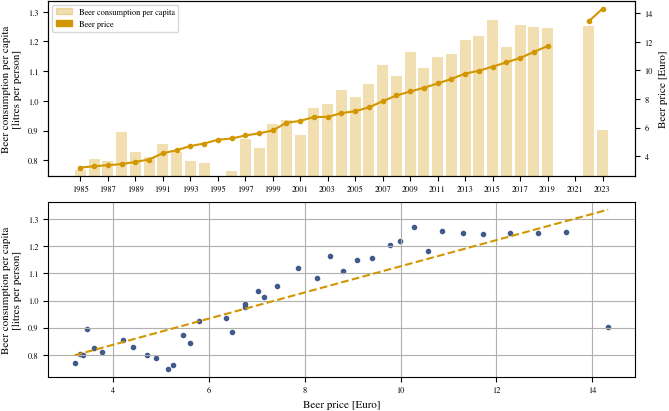

In [5]:
plt.rcParams.update(bundles.icml2022(column="full", nrows=2, ncols=2, usetex=False))
fig, ax = plt.subplots(2)

# Ading extra column for the beer consumption scaled by the visitor number for a specific year
df["beer_per_capita"] = (df["bier_konsum"]*100)/(df["besucher_gesamt"]*1000000)  # litres per person

# Plotting beer consumption
ax[0].bar(df["jahr"], df["beer_per_capita"], color=rgb.tue_orange, alpha=0.3)
ax[0].set_ylim(df["beer_per_capita"].min())
ax[0].set_ylabel('Beer consumption per capita\n[litres per person]')

# Set up second axis for the beer price
ax0 = ax[0].twinx()
ax0.plot(df["jahr"], df["bier_preis"], marker='.', color=rgb.tue_orange)
ax0.set_xticks(df['jahr'][::2])
ax0.set_xlabel('Year')
ax0.set_ylabel('Beer price [Euro]')

# Creating the legend
beer_consumption = mpatches.Patch(color=rgb.tue_orange, alpha=0.3, label='Beer consumption per capita')
beer_price = mpatches.Patch(color=rgb.tue_orange, label='Beer price')
plt.legend(handles=[beer_consumption, beer_price])


# For the correlation, interpolate the missing price and consumption values for 2020 and 2021
df['bier_preis'].interpolate(inplace=True)
df['bier_konsum'].interpolate(inplace=True)
df["beer_per_capita"].interpolate(inplace=True)

# Plotting correlation between beer price and consumption per capita
ax[1].scatter(df['bier_preis'],df['beer_per_capita'], color=rgb.tue_darkblue, marker='.')

# Adding trendline
z = np.polyfit(df['bier_preis'],df['beer_per_capita'], 1)
p = np.poly1d(z)
ax[1].plot(df['bier_preis'], p(df['bier_preis']), color=rgb.tue_orange, linestyle="--")
ax[1].grid(True)
ax[1].set_xlabel('Beer price [Euro]')
ax[1].set_ylabel('Beer consumption per capita\n[litres per person]')

plt.savefig('doc/fig/beer_consumption.pdf')
plt.show()

We see an almost linear increase in beer price over the years. The Oktoberfest has grown in popularity since 1985 and now also attracts many international tourists. This might explain why people are willing to spend more on a "Maß" beer, especially for some international tourists who might be used to paying the same prices in their home country.
The consumption also shows an overall increase, but fluctuates over the years.

The correlation plot shows that beer consumption continues to increase, despite rising beer prices. 
We also see an outlier of a very low per capita beer consumption in 2023. This could be due to the large number of visitors that scale the per capita consumption, or perhaps due to the hot weather during last year's Oktoberfest many people opted for non-alcoholic beverages, e.g. water. 2023 was also the first year that introduced free water fountains at the festival.

In [18]:
df["bier_preis"].corr(df["beer_per_capita"])

0.8452139452748796

The correlation coefficient confirms the strong positive relationship we see in the plot above.

## How does the roast chicken price change over the years and how does it affect the consumption?

We now do the same steps as above, but instead we investigate the roast chicken consumption and prices.

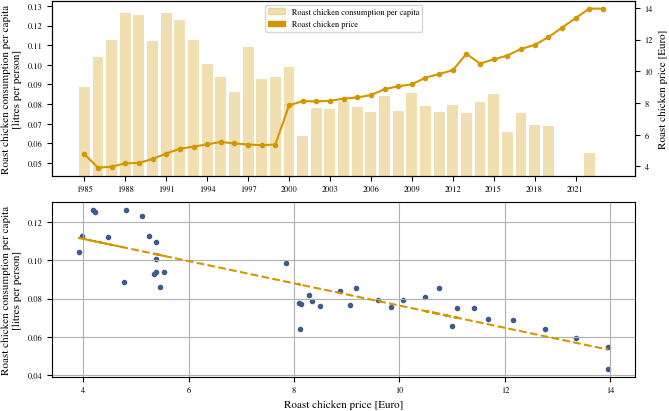

In [7]:
fig, ax = plt.subplots(2)

# Adding extra column for the chicken consumption scaled by the visitor number for a specific year
df["hendl_per_capita"] = (df["hendl_konsum"])/(df["besucher_gesamt"]*1000000)

# Plotting chicken consumption
ax[0].bar(df["jahr"], df["hendl_per_capita"], color=rgb.tue_orange, alpha=0.3)
ax[0].set_ylim(df["hendl_per_capita"].min())
ax[0].set_ylabel('Roast chicken consumption per capita\n[litres per person]')

# Set up second axis for the chicken price
ax0 = ax[0].twinx()
ax0.plot(df["jahr"], df["hendl_preis"], marker='.', color=rgb.tue_orange)
ax0.set_xticks(df['jahr'][::3])
ax0.set_xlabel('Year')
ax0.set_ylabel('Roast chicken price [Euro]')

# Creating the legend
hendl_consumption = mpatches.Patch(color=rgb.tue_orange, alpha=0.3, label='Roast chicken consumption per capita')
hendl_price = mpatches.Patch(color=rgb.tue_orange, label='Roast chicken price')
plt.legend(handles=[hendl_consumption, hendl_price],loc='upper center')

# For the correlation, interpolate the missing price and consumption values for 2020 and 2021
df['hendl_preis'].interpolate(inplace=True)
df['hendl_konsum'].interpolate(inplace=True)
df["hendl_per_capita"].interpolate(inplace=True)

# Plotting correlation between beer price and consumption per capita
ax[1].scatter(df['hendl_preis'],df['hendl_per_capita'], color=rgb.tue_darkblue, marker='.')

# Adding trendline
z = np.polyfit(df['hendl_preis'],df['hendl_per_capita'], 1)
p = np.poly1d(z)
ax[1].plot(df['hendl_preis'], p(df['hendl_preis']), color=rgb.tue_orange, linestyle="--")
ax[1].grid(True)
ax[1].set_xlabel('Roast chicken price [Euro]')
ax[1].set_ylabel('Roast chicken consumption per capita\n[litres per person]')

plt.show()

The chicen prices increase over the years, however we observe a drastic spike in price in the year 2000. This is possibly due to a change in how the prices were recorded. The year 2013 also shows a price outlier, where the price increased more than usual and then decreased again in the next year.

The correlation plot shows that the chicken consumption decreases as the price increases. Interestingly, the trend here is opposite to what we saw with the beer consumption. The reason for the decrease in consumption might have less to do with the increase in price, but rather with the rise in popularity of other foods.

In [20]:
df["hendl_preis"].corr(df["hendl_per_capita"])

-0.86791004476888

The correlation coefficient confirms the strong negative relationship we observed above.

## What is the total spend per visitor?

How does the total money spent on beer and chicken change over the years?

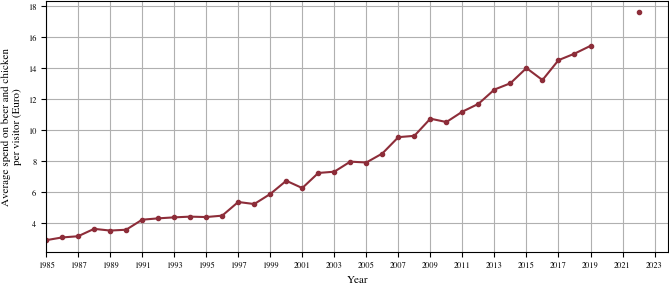

In [21]:
df['total_spend'] = ((df.iloc[:-1]['bier_konsum']*100*df.iloc[:-1]['bier_preis'])/(df.iloc[:-1]['besucher_gesamt']*1000000) + 
                     (df.iloc[:-1]['hendl_konsum']*df.iloc[:-1]['hendl_preis'])/(df.iloc[:-1]['besucher_gesamt']*1000000))

plt.rcParams.update(bundles.icml2022(column="full", nrows=0.7, ncols=1, usetex=False))
df.plot("jahr", "total_spend",legend=None, marker='.', color=rgb.tue_red)
plt.xlim(df['jahr'].min())
plt.xticks(df['jahr'][::2])
plt.xlabel("Year")
plt.ylabel("Average spend on beer and chicken\nper visitor [Euro]")
plt.grid(True)
plt.show()

It seems that people are willing to spend more money on beer and food every year. This makes sense since salaries also increase over the years, and so on average people can usually afford to spend more money.

## Comparing the rising beer prices to the inflation rate in Germany

A complaint often heard at the festival is how much the price of beer increases every year. Is the price increase unusually high or does it actually follow the trend of the inflation rate in Germany?

To compare the rising beer prices to the inflation we use the German inflation rate data from Destatis (Statistisches Bundesamt): https://www-genesis.destatis.de/genesis/online?sequenz=tabelleErgebnis&selectionname=61111-0001&startjahr=1991#abreadcrumb. 
The inflation rate is measured as the change in the Consumer Price Index compared to the previous year. 

In [8]:
# Reading in the inflation rate data
inflation_CPI = pd.read_csv("dat/inflation.csv", encoding="unicode_escape", sep=";", header=None)
inflation = inflation_CPI.iloc[0:, [0,2]]
inflation.columns=['jahr', 'inflation_rate']
inflation['inflation_rate'] = inflation['inflation_rate'].replace('.', np.nan)
inflation['inflation_rate'] = inflation['inflation_rate'].str.replace(',', '.').astype(float)

# Adding a column for the change in beer price compared to the previous year
inflation["beer_price_increase"] = df["bier_preis"].diff()
inflation = inflation[(inflation['jahr'] >= 1992) & (inflation['jahr'] <= 2019)]

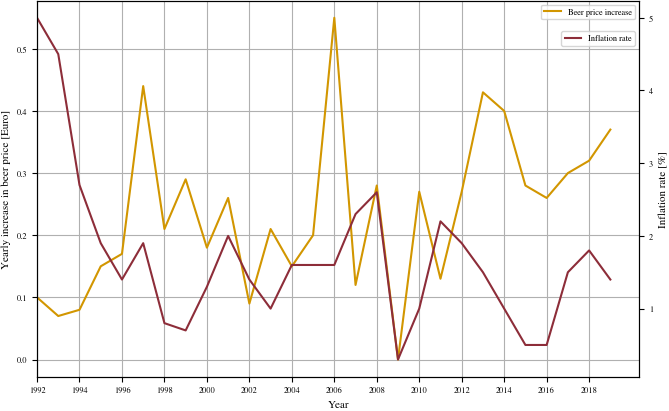

In [9]:
fig, ax = plt.subplots()

inflation.plot(x="jahr", y="beer_price_increase", ax=ax, label="Beer price increase",color=rgb.tue_orange)
ax2 = ax.twinx()
inflation.plot(x="jahr", y="inflation_rate", ax=ax2, label="Inflation rate", color=rgb.tue_red)
ax.set_ylabel("Yearly increase in beer price [Euro]")
ax2.set_ylabel("Inflation rate [%]")
ax.set_xlabel("Year")
ax.set_xticks(inflation['jahr'][::2])
plt.xlim(inflation['jahr'].min())
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.0))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.93))
plt.show()

We see that the change in beer price seems to roughly follow the trend of the inflation rate, however several peaks are unique to the beer price. Overall it seems that prices are in line with what we would expect by looking at the inflation rate.

### Adjusting beer prices by the Consumer Price Index (CPI)

We observed a positive relationship between beer consumption and prices, however part of that relationship could be driven by inflation. Adjusting for inflation helps to isolate the changes in real beer prices from changes caused by general price increases in the economy. The CPI measures the monthly average price development of all goods and services that private households in Germany purchase for consumption purposes. 

In [11]:
# Creating CPI df
CPI = inflation_CPI.iloc[0:, [0,1]]
CPI.columns=['jahr', 'CPI']
CPI['CPI'] = CPI['CPI'].str.replace(',', '.').astype(float)

df = pd.merge(df, CPI, on='jahr', how='outer')
df['CPI_adjusted_beer_price'] = df['bier_preis']/df['CPI'] *100

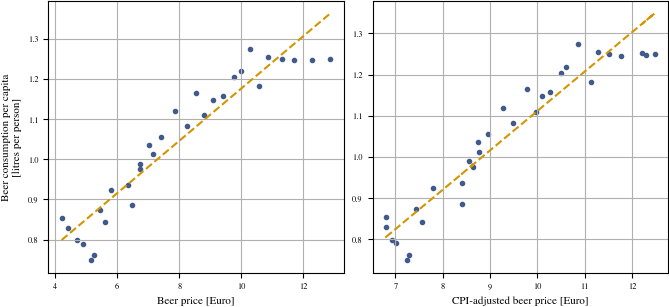

In [12]:
plt.rcParams.update(bundles.icml2022(column="full", nrows=1.5, ncols=2, usetex=False))
fig, ax = plt.subplots(1,2)

# We only plot the rows for which we also have CPI data
ax[0].scatter(df['bier_preis'].iloc[6:37],df['beer_per_capita'].iloc[6:37], color=rgb.tue_darkblue, marker='.')
z = np.polyfit(df['bier_preis'].iloc[6:37],df['beer_per_capita'].iloc[6:37], 1)
p = np.poly1d(z)
ax[0].plot(df['bier_preis'].iloc[6:37], p(df['bier_preis'].iloc[6:37]), color=rgb.tue_orange, linestyle="--")
ax[0].grid(True)
ax[0].set_xlabel('Beer price [Euro]')
ax[0].set_ylabel('Beer consumption per capita\n[litres per person]')

ax[1].scatter(df['CPI_adjusted_beer_price'],df['beer_per_capita'], marker='.', color=rgb.tue_darkblue)
z = np.polyfit(df['CPI_adjusted_beer_price'].iloc[6:37],df['beer_per_capita'].iloc[6:37], 1)
p = np.poly1d(z)
ax[1].plot(df['CPI_adjusted_beer_price'], p(df['CPI_adjusted_beer_price']), color=rgb.tue_orange, linestyle="--")
ax[1].grid(True)
ax[1].set_xlabel('CPI-adjusted beer price [Euro]')

plt.show()

We see that although the range in beer price decreases after adjusting by the CPI, the trend remains almost exactly the same.
Let's confirm by looking at the correlation coefficents:

In [29]:
print("Correlation between price and consumption:",df["bier_preis"].iloc[6:37].corr(df["beer_per_capita"].iloc[6:37]))
print("Correlation between CPI-adjusted price and consumption:",df["CPI_adjusted_beer_price"].corr(df["beer_per_capita"]))

Correlation between price and consumption: 0.9472701194520912
Correlation between CPI-adjusted price and consumption: 0.9547504138384966


Adjusting by the CPI slightly increased the correlation between price and consumption. The correlation coefficent for the non-adjusted price increased substantially from the one calculated previously, due to the exclusion of the 2023 outlier.